<a href="https://colab.research.google.com/github/Mayank-Konduri/Summer2025_Mayank_Prof.Chen_Patricia/blob/main/Mayank_Summer_2025_Experiment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Experiment No.2 - Visualizing The Cones**

**This Google Colab Notebook is split into different sections:**
**This Google Colab Notebook is split into different sections:**

<br>

**Step I -** Import Necessary Dependencies


**Step II -** Select Digits


**Step III -** Preprocess Digits

**Task I -** Train a Neural Network [based on CE24]


**Task II -** Determine cumulative parameters $W^{(\ell)}, b^{(\ell)}$


**Task III -** Determine cones


**Task IV -** PCA Visualization for Cones and Data


**Task V -** In-Depth Analysis and Detailed Visualization
<br>

---

<br>

**Step I -** Import Necessary Dependencies


**Step II -** Select Digits


**Step III -** Preprocess Digits

**Task I -** Train a Neural Network [based on CE24]


**Task II -** Determine cumulative parameters $W^{(\ell)}, b^{(\ell)}$


**Task III -** Determine cones


**Task IV -** PCA Visualization for Cones and Data


**Task V -** In-Depth Analysis and Detailed Visualization
<br>

---


**Step I - Import Necessarry Dependencies**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
from numpy.linalg import pinv
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

**Step II - Select Digits**

In [2]:
selected_digits = [5, 6, 7]
Q = len(selected_digits)     # number of classes
L = Q + 1                    # total layers

print(f"Using digits: {selected_digits} | Q = {Q} | L = {L}")

Using digits: [5, 6, 7] | Q = 3 | L = 4


**Step III - Preprocess Digits**

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # flatten 28x28 to 784
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


train_mask = torch.zeros_like(train_dataset.targets, dtype=torch.bool)
test_mask = torch.zeros_like(test_dataset.targets, dtype=torch.bool)


for digit in selected_digits:
    train_mask |= (train_dataset.targets == digit)
    test_mask |= (test_dataset.targets == digit)

# create filters
train_dataset.targets = train_dataset.targets[train_mask]
train_dataset.data    = train_dataset.data[train_mask]
test_dataset.targets = test_dataset.targets[test_mask]
test_dataset.data    = test_dataset.data[test_mask]

# remap labels to {0,...,Q-1}
label_map = {digit: idx for idx, digit in enumerate(selected_digits)}
train_dataset.targets = torch.tensor([label_map[label.item()] for label in train_dataset.targets])
test_dataset.targets = torch.tensor([label_map[label.item()] for label in test_dataset.targets])


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# confirm size and flattened shape
images, labels = next(iter(train_loader))
print(f"Batch images shape: {images.shape}")
print(f"Batch labels shape: {labels.shape}")
images, labels = next(iter(test_loader))
print(f"Test batch images shape: {images.shape}")
print(f"Test batch labels shape: {labels.shape}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 133MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 33.7MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 61.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.49MB/s]


Train samples: 17604
Test samples: 2878
Batch images shape: torch.Size([64, 784])
Batch labels shape: torch.Size([64])
Test batch images shape: torch.Size([64, 784])
Test batch labels shape: torch.Size([64])


**Task I - Train a Neural Network [based on CE24]**

<img src="https://drive.google.com/uc?export=view&id=1lhQeAp1Gw3r0leP0SsrouDM10HPg6fIs" width="850
">

<img src="https://drive.google.com/uc?export=view&id=1YLvC6098HwbE42kK14GaeQL8RPmsVt5J" width="850">


**Based on Theorem 5.2 in the hyperplanes paper [CE24], the suggested architecture is:**

**Layers:** L = Q + 1 *(ex: 3+1)*

**Input dim:** d₀ = M *(ex: 784)*

**Hidden layers:** all same width M ≥ Q *(ex: 784 = 784 = 784 > 3)*

**Last layer:** output dim = Q *(ex: 3)*

**Weight matrices:** recursively defined

**Bias vectors:** recursively defined

In [9]:
# ReLU Feedforward Network
class TruncationNet(nn.Module):
    def __init__(self, input_dim=784, hidden_dims=[784, 784, 784], output_dim=3): # 3 hidden layers (Q) + 1 output layer, should output_dim be 3 or 10?
        super().__init__()
        dims = [input_dim] + hidden_dims + [output_dim]
        self.layers = nn.ModuleList([
            nn.Linear(dims[i], dims[i+1]) for i in range(len(dims)-1)
        ])

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        return self.layers[-1](x)

model = TruncationNet()
print(model)

TruncationNet(
  (layers): ModuleList(
    (0-2): 3 x Linear(in_features=784, out_features=784, bias=True)
    (3): Linear(in_features=784, out_features=3, bias=True)
  )
)


In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) # gradient descent
criterion = nn.CrossEntropyLoss()

epochs = 10
for epoch in range(epochs):
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward() # backpropogation
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

print("Training done!")

# ---------------------------------------------------------
# testing is not needed for this project, but I want to make sure model is accurate
# ---------------------------------------------------------

model.eval()

correct = 0
total = 0

with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        pred = output.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += target.size(0)

test_acc = correct / total
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Epoch 1, Loss: 0.1205
Epoch 2, Loss: 0.0003
Epoch 3, Loss: 0.0023
Epoch 4, Loss: 0.0024
Epoch 5, Loss: 0.0039
Epoch 6, Loss: 0.0009
Epoch 7, Loss: 0.0000
Epoch 8, Loss: 0.0030
Epoch 9, Loss: 0.0026
Epoch 10, Loss: 0.0000
Training done!
Test Accuracy: 99.10%


**Task II – Determine cumulative parameters $W^{(\ell)}, b^{(\ell)}$**

<img src="https://drive.google.com/uc?export=view&id=1ow75T0DgfPrJ8AUMroYGHwwh_38b_quV" width="500">


In [11]:
# extracting weights and biases
Ws = []
bs = []
for layer in model.layers:
    Ws.append(layer.weight.detach().clone())
    bs.append(layer.bias.detach().clone())

L = len(Ws)  # should equal Q+1
L1 = len(bs) # should equal Q+1

print("Weights Length: ", L)
print("Biases Length: ", L1)

Weights Length:  4
Biases Length:  4


<img src="https://drive.google.com/uc?export=view&id=1qf8eD4PR3Nlopat2C9Xrc2wP4qQLS0XJ" width="850">


> I attached hand-written work for the explicit calculation of the **cumulative weights (Proposition 2.5)** since they are just simple chain of matrix multiplications **[CE24]**.

> For the **cumulative biases (Proposition 2.6)**, the derivation is straightforward but the implementation is more expansive, so I commented that part in the code instead of writing it all out **[CE24]**.

<img src="https://drive.google.com/uc?export=view&id=1vuPBv1QZvALNPlJOyD1o1P5dLX2p6-Cx" width="850">


The main idea for the calculations is:  
- **Cumulative weight** up to layer ℓ is just the product of all weight matrices up to that layer.
- **Cumulative bias** up to layer ℓ is a sum: each previous bias is multiplied by all the weights that come after it, then you add the current layer's bias.

**This matches the formulas from the [CE24] paper**  

In [12]:
W_cum_chain = []
b_cum_chain = []

for ell in range(L):  # loop through each layer
    if ell == 0:
        # for the first layer, cumulative weight and bias are just themselves
        Wcum = Ws[0]
        bcum = bs[0]
    else:
        # multiply the current layer's weight by the total weight so far
        Wcum = Ws[ell] @ W_cum_chain[-1]

        # for the bias:
        # start at zero, and for each previous bias, multiply it by all the weights that come after it (so they affect how the bias carries forward)
        btemp = 0
        for k in range(ell):
            chain = Ws[ell]
            for j in range(ell-1, k, -1):
                chain = chain @ Ws[j]
            btemp += chain @ bs[k]

        # finally add the current layer's bias
        bcum = btemp + bs[ell]

    print(f"Layer {ell+1}: W_cum shape = {Wcum.shape}, b_cum shape = {bcum.shape}")
    W_cum_chain.append(Wcum) # adds the current layer's cumulative weight to the final array
    b_cum_chain.append(bcum) # adds the current layer's cumulative bias to the final array

Layer 1: W_cum shape = torch.Size([784, 784]), b_cum shape = torch.Size([784])
Layer 2: W_cum shape = torch.Size([784, 784]), b_cum shape = torch.Size([784])
Layer 3: W_cum shape = torch.Size([784, 784]), b_cum shape = torch.Size([784])
Layer 4: W_cum shape = torch.Size([3, 784]), b_cum shape = torch.Size([3])


In [13]:
#manually checking if the calculated cumulative parameters are correct

# layer 1
W1_manual = Ws[0]
b1_manual = bs[0]

print("\nLayer 1:")
print("W_cum correct?", torch.allclose(W_cum_chain[0], W1_manual, atol=1e-6))
print("b_cum correct?", torch.allclose(b_cum_chain[0], b1_manual, atol=1e-6))

# layer 2
W2_manual = Ws[1] @ Ws[0]
b2_manual = Ws[1] @ bs[0] + bs[1]

print("\nLayer 2:")
print("W_cum correct?", torch.allclose(W_cum_chain[1], W2_manual, atol=1e-6))
print("b_cum correct?", torch.allclose(b_cum_chain[1], b2_manual, atol=1e-6))

# layer 3
W3_manual = Ws[2] @ Ws[1] @ Ws[0]
b3_manual = Ws[2] @ Ws[1] @ bs[0] + Ws[2] @ bs[1] + bs[2]

print("\nLayer 3:")
print("W_cum correct?", torch.allclose(W_cum_chain[2], W3_manual, atol=1e-6))
print("b_cum correct?", torch.allclose(b_cum_chain[2], b3_manual, atol=1e-6))

# layer 4
W4_manual = Ws[3] @ Ws[2] @ Ws[1] @ Ws[0]
b4_manual = Ws[3] @ Ws[2] @ Ws[1] @ bs[0] + Ws[3] @ Ws[2] @ bs[1] + Ws[3] @ bs[2] + bs[3]

print("\nLayer 4:")
print("W_cum correct?", torch.allclose(W_cum_chain[3], W4_manual, atol=1e-6))
print("b_cum correct?", torch.allclose(b_cum_chain[3], b4_manual, atol=1e-6))


Layer 1:
W_cum correct? True
b_cum correct? True

Layer 2:
W_cum correct? True
b_cum correct? True

Layer 3:
W_cum correct? True
b_cum correct? True

Layer 4:
W_cum correct? True
b_cum correct? True


**Task III – Determine cones**
> "can use polyhedral cones from [Ewa25] and determine the base point and edges."

<img src="https://drive.google.com/uc?export=view&id=1QaKTPRJB2AZVF70HT6_ZeLiUASzBZkhN" width="850">


<img src="https://drive.google.com/uc?id=1klBXHqR40XDl1Qbl9aTAxiG81u3SqbTu" width="850">


As it was stated in **Lemma 2.1** in [Ewa25], a truncation map for a ReLU neural network can be described in terms of **polyhedral cones** defined by a base point and edges.

In my implementation, I use the **cumulative weights and biases** for each layer to construct these cones exactly as in the paper:

$$
p^{(\ell)} = - (W^{(\ell)})^{+} b^{(\ell)},
\quad
v_i^{(\ell)} = (W^{(\ell)})^{+} e_i.
$$

This gives two polyhedral cones for each layer:

$$
S_{+} = \Big\{\, p + \sum a_i v_i : a_i \geq 0 \Big\},
\quad
S_{-} = \Big\{\, p + \sum a_i v_i : a_i \leq 0 \Big\}.
$$


My implementation fully matches **Lemma 2.1 and Equations (2.14–2.15)** in the paper.


In [14]:
def compute_cones(W_cum, b_cum, residual_tol=1e-4):
    cones = []
    for ell, (W, b) in enumerate(zip(W_cum, b_cum)):

        # making sure everything is pure NumPy (got warning before)
        if hasattr(W, 'detach'): W = W.detach().cpu().numpy()
        if hasattr(b, 'detach'): b = b.detach().cpu().numpy()

        # compute the pseudoinverse of W
        W_pinv = np.linalg.pinv(W)

        # compute base point: p = - W^+ b [Ewa25]
        p = -W_pinv @ b

        # compute edges: v_i = W^+ e_i for standard basis vectors e_i [Ewa25]
        m = W.shape[0]
        edges = []
        edge_residuals = []

        for i in range(m):
            ei = np.zeros(m)
            ei[i] = 1
            vi = W_pinv @ ei
            edges.append(vi)

            residual = np.linalg.norm(W @ vi - ei)
            edge_residuals.append(residual)

        cones.append({'base': p, 'edges': edges})

        print(f"\n=== Layer {ell+1} Cone Checks ===")

        # Surjectivity check (Lemma 2.1)
        rank = np.linalg.matrix_rank(W)
        rows, cols = W.shape
        print(f"Rank(W) = {rank} | Should be full row rank = {rows}")
        if rank == rows:
            print("✅ Surjective check passed, it is full row rank")
        else:
            print("⚠️ Not surjective")

        # Base point residual check
        base_residual = np.linalg.norm(W @ p + b)
        if base_residual <= residual_tol:
            print(f"✅ Base point residual ||Wp + b|| = {base_residual:.2e} (OK)")
        else:
            print(f"⚠️ Base point residual ||Wp + b|| = {base_residual:.2e} exceeds tolerance")

        # Edge residuals check
        edge_residuals = np.array(edge_residuals)
        num_failed_edges = np.sum(edge_residuals > residual_tol)
        mean_edge_residual = np.mean(edge_residuals)

        if num_failed_edges == 0:
          print(f"✅ All edge checks passed | Failing: {num_failed_edges}/{m} | Mean residual: {mean_edge_residual:.2e}")
        else:
          print(f"⚠️ Some edge residuals exceed tolerance | Failing: {num_failed_edges}/{m} | Mean residual: {mean_edge_residual:.2e}")

        print(f"------------------")

        # Overall pass/fail summary
        if rank == rows and base_residual <= residual_tol and num_failed_edges == 0:
            print("✅ Lemma 2.1 conditions are met")
        else:
            print("⚠️ Lemma 2.1 conditions are not met")

    return cones

cones = compute_cones(W_cum_chain, b_cum_chain)


=== Layer 1 Cone Checks ===
Rank(W) = 784 | Should be full row rank = 784
✅ Surjective check passed, it is full row rank
✅ Base point residual ||Wp + b|| = 1.07e-05 (OK)
✅ All edge checks passed | Failing: 0/784 | Mean residual: 3.52e-06
------------------
✅ Lemma 2.1 conditions are met

=== Layer 2 Cone Checks ===
Rank(W) = 777 | Should be full row rank = 784
⚠️ Not surjective
⚠️ Base point residual ||Wp + b|| = 2.61e-03 exceeds tolerance
⚠️ Some edge residuals exceed tolerance | Failing: 667/784 | Mean residual: 3.37e-04
------------------
⚠️ Lemma 2.1 conditions are not met

=== Layer 3 Cone Checks ===
Rank(W) = 744 | Should be full row rank = 784
⚠️ Not surjective
⚠️ Base point residual ||Wp + b|| = 1.57e-01 exceeds tolerance
⚠️ Some edge residuals exceed tolerance | Failing: 784/784 | Mean residual: 3.03e-02
------------------
⚠️ Lemma 2.1 conditions are not met

=== Layer 4 Cone Checks ===
Rank(W) = 3 | Should be full row rank = 3
✅ Surjective check passed, it is full row rank
✅

<img src="https://drive.google.com/uc?id=1KGEPG3BHTJZV0iPKTrk-f6SlWCEHaaa1" width="850">


* Lemma 2.2 states that if
𝑊 is injective (columns full rank but rows not full rank), then the cone defined by 𝑊 can be lifted into a higher-dimensional space.

<img src="https://drive.google.com/uc?id=1-A0NEQq5UahVImJYBeNkTR4N_h853Vp6" width="850">


* If W is not injective, there is no action to do for now, **I can only interpret the cone inside the active subspace (the image of 𝑊).**


* These ranks come directly from the learned weight matrices W.
This means the layer is doing dimension reduction, or its parameters collapsed during training. I think this is common with over-parameterized MLPs, especially if I have more neurons than I actually need.

* Moreover, MNIST is low dimensional & redundant, so some layers naturally become rank deficient.

* So cones are correct?... They just don’t span the entire input space at each layer.

In [15]:
def check_injective(W_cum, b_cum, residual_tol=1e-4):
    results_injective = []
    for ell, (W, b) in enumerate(zip(W_cum, b_cum)):

        if hasattr(W, 'detach'): W = W.detach().cpu().numpy()
        if hasattr(b, 'detach'): b = b.detach().cpu().numpy()

        rank = np.linalg.matrix_rank(W)
        rows, cols = W.shape

        print(f"\n=== Layer {ell+1} ===")
        print(f"Rank(W) = {rank} | Rows = {rows} | Columns = {cols}")

        if rank == rows:
            print("✅ Surjective: full row rank")
        else:
            print("⚠️ Not surjective")
            if rank == cols:
                print("✅ Injective: full column rank, can apply Lemma 2.2 to extend cone in higher dimensions.")
            else:
                print("⚠️ Not injective either, cone only valid in lower-dimensional subspace.")

    return results_injective

results_injective = check_injective(W_cum_chain, b_cum_chain)


=== Layer 1 ===
Rank(W) = 784 | Rows = 784 | Columns = 784
✅ Surjective: full row rank

=== Layer 2 ===
Rank(W) = 777 | Rows = 784 | Columns = 784
⚠️ Not surjective
⚠️ Not injective either, cone only valid in lower-dimensional subspace.

=== Layer 3 ===
Rank(W) = 744 | Rows = 784 | Columns = 784
⚠️ Not surjective
⚠️ Not injective either, cone only valid in lower-dimensional subspace.

=== Layer 4 ===
Rank(W) = 3 | Rows = 3 | Columns = 784
✅ Surjective: full row rank


**Task IV – PCA Visualization for Cones and Data**
> "Initially I was just thinking to have a look at what the cones look like, maybe superimposed with the initial data."

<img src="https://drive.google.com/uc?id=1cuj_9ZImDcRaMFZIDCMv083nWDQUO2i9" width="850">


**Given the instructions, I broke the task down into smaller steps:**

> **"Do principal component analysis (PCA) on training data."**

Step 1. Gather training data  
Step 2. Do PCA on training data  
Step 3. Scatterplot of PCA data  

> **"Use these coordinates and project cones (base point and edges) as well, superimposed with the initial data."**

Step 4. Pick **which cone** to visualize  
Step 5. Project **base point** to PCA  
Step 6. Project **edges** to PCA  
Step 7. Plot base + edges on top of scatterplot

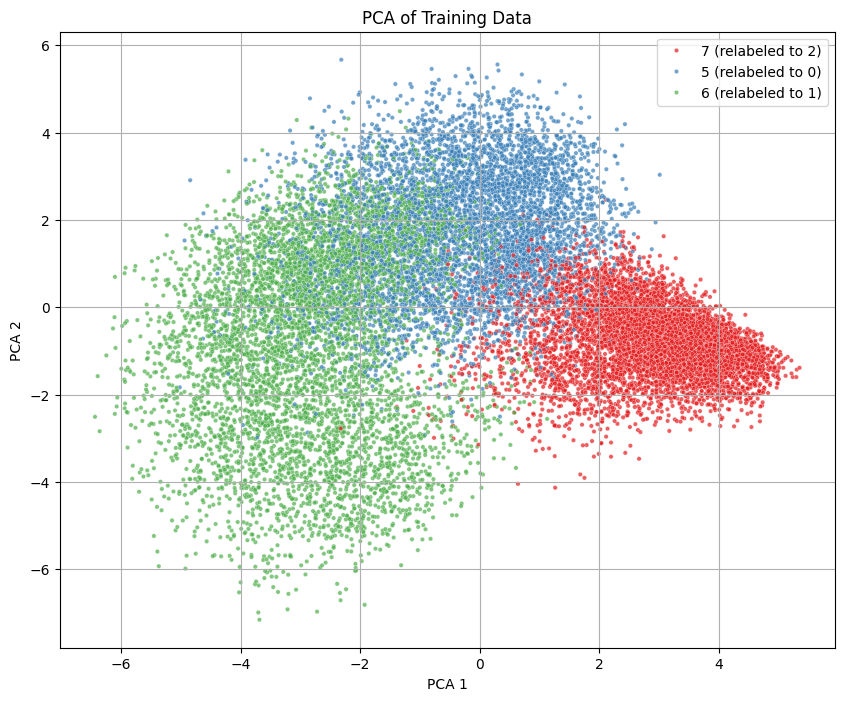

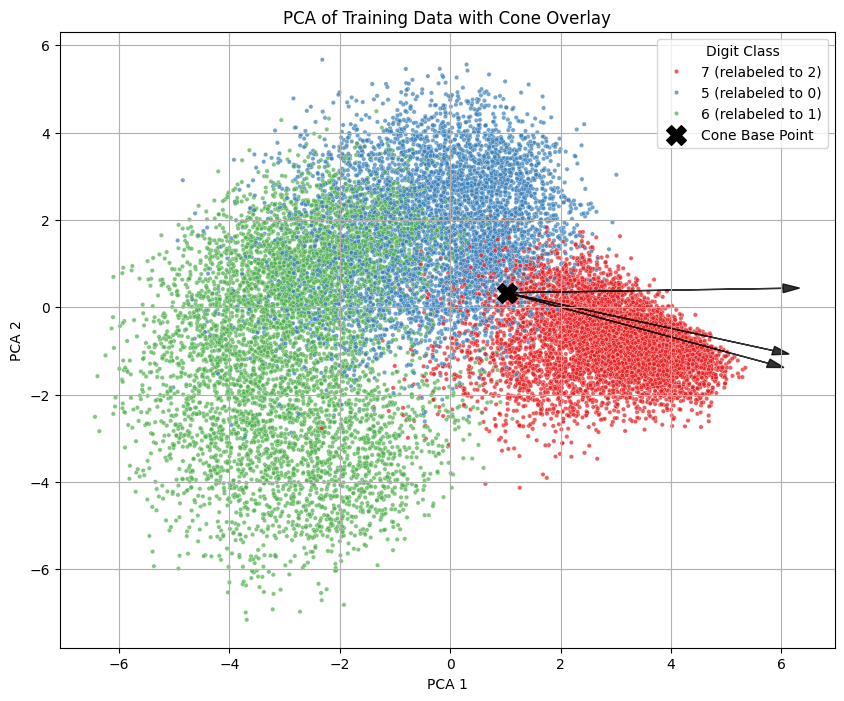

In [16]:
#---------------------------------------------------------
# Step 1
#---------------------------------------------------------

X_train = []
y_train = []

for batch, labels in train_loader:
    X_train.append(batch)
    y_train.append(labels)

X_train = torch.cat(X_train, dim=0).numpy()
y_train = torch.cat(y_train, dim=0).numpy()

#---------------------------------------------------------
# Step 2
#---------------------------------------------------------

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

#---------------------------------------------------------
# Step 3
#---------------------------------------------------------

# create a mapping like: "1 (relabeled to 0)" to make plot easier to read
inv_map = {v: k for k, v in label_map.items()}
label_names = [f"{inv_map[y]} (relabeled to {y})" for y in y_train]

df = pd.DataFrame({
    "PCA1": X_train_pca[:, 0],
    "PCA2": X_train_pca[:, 1],
    "Label": label_names
})

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df,
    x=X_train_pca[:, 0],
    y=X_train_pca[:, 1],
    hue="Label",
    palette='Set1',
    s=10,
    alpha=0.7
)

plt.title("PCA of Training Data")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.show()

#---------------------------------------------------------
# Step 4
#---------------------------------------------------------

cone = cones[-1]
p = cone['base']    # base point, shape [784]
edges = cone['edges']  # list of v_i

#---------------------------------------------------------
# Step 5
#---------------------------------------------------------

p_proj = pca.transform(p.reshape(1, -1)).flatten()

#---------------------------------------------------------
# Step 6
#---------------------------------------------------------

edges_proj = [] # projected endpoints
for vi in edges:
    vi_proj = pca.transform(vi.reshape(1, -1)).flatten()  # [2]
    edges_proj.append(vi_proj)

edges_dirs = [vi_proj - p_proj for vi_proj in edges_proj] #projected direction vectors relative to the base, this is needed for plt.arrow

#---------------------------------------------------------
# Step 7
#---------------------------------------------------------

plt.figure(figsize=(10, 8))

# Scatter plot of PCA training data points
sns.scatterplot(
    data=df,
    x="PCA1",
    y="PCA2",
    hue="Label",
    palette='Set1',
    s=10,
    alpha=0.7
)

# Plot base point
plt.scatter(
    p_proj[0], p_proj[1],
    marker='X', s=200, color='black',
    label='Cone Base Point'
)

# Plot edges as arrows
for dir_proj in edges_dirs:
    norm = np.linalg.norm(dir_proj)
    if norm > 0:
        scaled_dir = dir_proj / norm * 5  # adjust scale for visibility
        plt.arrow(
            p_proj[0], p_proj[1],
            scaled_dir[0], scaled_dir[1],
            head_width=0.2, head_length=0.3,
            color='black', alpha=0.8
        )

plt.title("PCA of Training Data with Cone Overlay")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Digit Class")
plt.grid(True)
plt.show()

**Task V - In-Depth Analysis and Detailed Visualization**

> **"It would be very cool to also have graphic visualization of the cones transforming the data, but that can come later."**

Any input point (data) can be tested by solving for the coefficients $a_i$. This shows which region the point falls in and how the truncation map acts (if the truncation map transforms the point):
- for each cone, points in $S_{+}$ pass unchanged,
- for each cone, points in $S_{-}$ are mapped to the base point $p$.


**The following is what I make out of the process in which data is transformed by cones:**

* Points that collapse in a cone get truncated and grouped near a base point or face, they often end up in the same class region.

* Points that stay fully active travel through the full cone and get classified based on their alignment with the cone edges.

* In the end, the classifier “matches” each point to the cone region that best fits, collapsed points and active points each go to the class sector they’re closest to.

